In [6]:
# !pip install mxnet
# !pip install gluonnlp pandas tqdm
# !pip install sentencepiece
# !pip install transformers==3
# !pip install torch
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, notebook

from torch.nn import init

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
# from transformers import AdamW
# kobert updated from using transformer 3.XX to using transformer 4.xx, optimizer import from torch,
from torch.optim import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit,StratifiedKFold
import random
import gc
import unicodedata

gc.collect()

42

In [8]:
############################################################################
############################################################################
############################################################################

##GPU 사용 시
# there are totally five GPU in server,we can routed to 0:4.
# device = torch.device("cuda:4")
gc.collect()

bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /home/dawn/IPC/For Journal Paper/imbalanced/.cache/kobert_v1.zip
using cached model. /home/dawn/IPC/For Journal Paper/imbalanced/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /home/dawn/IPC/For Journal Paper/imbalanced/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [9]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx,label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        
        self.sentences = []
        self.labels = []
#         for i in dataset:
#             self.sentences.append(transform([i[sent_idx]]))
#             self.labels.append(i[label_idx])
        for i in dataset:
            if len(i[sent_idx])<=max_len:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(i[label_idx])
            else:
                self.sentences.append(transform([i[sent_idx][:max_len]]))
                self.labels.append(i[label_idx])
        

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))
    
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=11,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [10]:
# define parameter
max_len = 128
batch_size = 32
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 20
learning_rate =  5e-6  #5e-5  2e-5
num_workers = 2
n_splits = 5
model_name = 'kobertbest_128.pt'

device = torch.device("cuda:4")

model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
# torch.save(model, 'kobert.pt')

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
torch.save({'modelA':model.state_dict(),'optimizerA':optimizer.state_dict()},'kobert.pt')

loss_fn = nn.CrossEntropyLoss()

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##################################################################################################
# train test validate split

# df_raw = pd.read_csv("extract100datasetmanual.csv?dl=1")
# df_raw = pd.read_csv("dataset200_12manually.csv")

#df_raw = pd.read_csv("12classesdatsetnew.csv",index_col=False )
# df_raw = pd.read_csv("class11to134.csv",index_col=False )
df_raw = pd.read_excel('11classesdatsetnew_20220208.xlsx', engine='openpyxl', sheet_name="classesdatsetnew", header=0)

# df_raw = pd.read_csv("dataset200_13manually2.csv")
# print(df_raw)
# categorylist = ["화장품","핫플레이스","요리음식","여행아웃도어","인테리어","엔터테인먼트"]

categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
temp_label=[]
for i in df_raw['label']:
    temp_label.append(categorylist.index(i))
df_raw['label']=temp_label

train_test_ratio = 0.8
df_train_list =[None]*11
df_test_list = [None]*11

df_file =[None] *11

for i, labeli in enumerate(range(len(categorylist))):
    df_file[i] = df_raw[df_raw['label'] == labeli]

for i, dffilei in enumerate(df_file):
    df_train_list[i],df_test_list[i] = train_test_split(dffilei,train_size = train_test_ratio, random_state = 1)

df_train = pd.concat([trainlist for trainlist in df_train_list],ignore_index=True,sort=False)
df_test = pd.concat([dftest for dftest in df_test_list],ignore_index=True,sort=False)

import re

df_traindata = df_train.reindex(columns=['label', 'caption'])
# df_traindata = df_train.reindex(columns=['label', 'hashtag'])
# print(df_traindata)
df_trainlabel = df_train.reindex(columns=['label'])
np_data = df_traindata.to_numpy()
np_label = df_trainlabel.to_numpy()

for i in range(len(np_data)):
    np_data[i][1] = unicodedata.normalize('NFC',np_data[i][1])
    np_data[i][1] = ' '.join(re.compile('[가-힣]+').findall(np_data[i][1]))

df_testdata = df_test.reindex(columns=['label', 'caption'])
# df_testdata = df_test.reindex(columns=['label', 'hashtag'])
df_testlabel = df_test.reindex(columns=['label'])
np_testdata = df_testdata.to_numpy()
np_testlabel = df_testlabel.to_numpy()

for i in range(len(np_testdata)):
    np_testdata[i][1] = unicodedata.normalize('NFC',np_testdata[i][1])
    np_testdata[i][1] = ' '.join(re.compile('[가-힣]+').findall(np_testdata[i][1]))

print(np_testdata)


[[0
  '허리까지 내려오는 긴 생머리 이번주에 드뎌 머리 하러 갑니당 두근두근 아비다선 샴푸는 벌써 두통째 사용하고 있는데 긴머리는 꾸준히 관리하지 않으면 영양이 쉽게 빠질 수 있어서 두피 손상 예방을 위해 꾸준히 사용중이에요 향도 좋은데 기능도 좋아서 남성분들께도 추천드려요 여성 남성 지성용으로 나뉘어져있으니 자신에게 맞는 걸로 추천드릴게요 아비다선 샴푸 헤어케어 헤어관리']
 [0
  '마스크에 다 묻어나는 파운데이션 멈춰 이제 여름인데 두꺼운 메이크업 계속 할 수 없잖어 바를수록 투명하게 맑아지는 턴온크림 바로 밀착되서 묻어남 도없는 턴온크림 겟하러 가즈아 초크림 올리브영추천템 톤업끝판왕 듀이셀 턴온크림 올리브영 톤업크림 턴온크림 화장품 코스메틱']
 [0
  '입니다 긴머리 때 잦은 염색 때문에 건조하고 푸석해져있던 머릿결 도브 인텐스 리페어 라인과 너리싱 오일케어 라인을 사용해 관리중이에요 확실히 건강하게 관리되는 것 같아요 도브의 특징인 은은하게 나는 향과 다양한 종류로 구성되어 있어서 취향에 맞게 사용할 수 있어요 스칼프 너리싱과 데일리 샤인라인도 월 리뉴얼 출시 예정이라는데 기대 즁 도브 도브샴푸 도브컨디셔너 도브헤어에센스 도브헤어세럼 헤어케어 샴푸 컨디셔너 헤어에센스 헤어세럼 모발관리']
 [0
  '피부 진정에 좋은 판테놀 토너 사용 후 리얼 카밍 세럼을 얇게 레이어링 해주세요 민감했던 피부를 토닥토닥 촉촉하게 보습 진정 시켜드릴게요 진정세럼 민감성피부 피부진정 세럼추천 트러블세럼 스킨케어 기초화장품 진정보습 데일리']
 [0
  '유료광고 봄을 맞이하며 봄 아이 메이크업으로 취향 저격 순하고 밀키한 컬러를 모두 담은 올테이크 무드 팔레트 봄바람아너는계획이있구나 런칭 기념 올리브영에서 할인가로 만나보세요 페리페라 순한맛']
 [0
  '유료광고 이제 음력으로도 정말 물러설 곳 없는 년 시작 새해 카운트다운 하면서 설화수 자음생에센스를 소개 해드리고 내 피부를 위해 꾸준히 쓰기로 약속했었는데요 건조함과 다양한 외부 자극이 늘어난 요즘 자음생

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/48 Cost: 2.501165 Train Acc 0.03125
Epoch 1/20 Batch 21/48 Cost: 2.520520 Train Acc 0.08333333333333333
Epoch 1/20 Batch 41/48 Cost: 2.544064 Train Acc 0.09375

Epoch 1/20 Cost: 2.370012 Train Acc 0.0975796568627451


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.370012 Test Acc 0.1284123563218391


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/48 Cost: 2.493831 Train Acc 0.03125
Epoch 2/20 Batch 21/48 Cost: 2.400838 Train Acc 0.10416666666666667
Epoch 2/20 Batch 41/48 Cost: 2.343713 Train Acc 0.12271341463414634

Epoch 2/20 Cost: 2.303292 Train Acc 0.12143841911764706


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.303292 Test Acc 0.1555316091954023


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/48 Cost: 2.445189 Train Acc 0.09375
Epoch 3/20 Batch 21/48 Cost: 2.490826 Train Acc 0.13392857142857142
Epoch 3/20 Batch 41/48 Cost: 2.342474 Train Acc 0.15015243902439024

Epoch 3/20 Cost: 2.374336 Train Acc 0.1539905024509804


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/20 Cost: 2.374336 Test Acc 0.22063577586206895


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/48 Cost: 2.325610 Train Acc 0.1875
Epoch 4/20 Batch 21/48 Cost: 2.230568 Train Acc 0.19345238095238096
Epoch 4/20 Batch 41/48 Cost: 2.190248 Train Acc 0.21646341463414634

Epoch 4/20 Cost: 2.058233 Train Acc 0.22977941176470587


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/20 Cost: 2.058233 Test Acc 0.3686242816091954


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/48 Cost: 2.049622 Train Acc 0.5
Epoch 5/20 Batch 21/48 Cost: 2.098387 Train Acc 0.33482142857142855
Epoch 5/20 Batch 41/48 Cost: 2.111708 Train Acc 0.36051829268292684

Epoch 5/20 Cost: 2.078235 Train Acc 0.371438419117647


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/20 Cost: 2.078235 Test Acc 0.6118893678160919


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/48 Cost: 1.876726 Train Acc 0.5
Epoch 6/20 Batch 21/48 Cost: 1.814704 Train Acc 0.5714285714285714
Epoch 6/20 Batch 41/48 Cost: 1.631260 Train Acc 0.5983231707317073

Epoch 6/20 Cost: 1.494794 Train Acc 0.6056985294117647


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/20 Cost: 1.494794 Test Acc 0.7767600574712644


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/48 Cost: 1.529116 Train Acc 0.8125
Epoch 7/20 Batch 21/48 Cost: 1.345725 Train Acc 0.7708333333333334
Epoch 7/20 Batch 41/48 Cost: 1.419612 Train Acc 0.791920731707317

Epoch 7/20 Cost: 1.322376 Train Acc 0.7905177696078431


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/20 Cost: 1.322376 Test Acc 0.8458153735632185


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/48 Cost: 1.306058 Train Acc 0.9375
Epoch 8/20 Batch 21/48 Cost: 1.274014 Train Acc 0.8556547619047619
Epoch 8/20 Batch 41/48 Cost: 1.186341 Train Acc 0.8666158536585366

Epoch 8/20 Cost: 1.137163 Train Acc 0.8724724264705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/20 Cost: 1.137163 Test Acc 0.8655711206896551


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/48 Cost: 1.073885 Train Acc 0.9375
Epoch 9/20 Batch 21/48 Cost: 0.950928 Train Acc 0.9047619047619048
Epoch 9/20 Batch 41/48 Cost: 1.086782 Train Acc 0.9100609756097561

Epoch 9/20 Cost: 0.933089 Train Acc 0.9089307598039215


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.933089 Test Acc 0.8788613505747126


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/48 Cost: 0.895067 Train Acc 0.96875
Epoch 10/20 Batch 21/48 Cost: 0.949202 Train Acc 0.9166666666666666
Epoch 10/20 Batch 41/48 Cost: 0.941920 Train Acc 0.9222560975609756

Epoch 10/20 Cost: 0.793774 Train Acc 0.927734375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.793774 Test Acc 0.8846084770114943


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/48 Cost: 0.943523 Train Acc 0.90625
Epoch 11/20 Batch 21/48 Cost: 0.914746 Train Acc 0.9375
Epoch 11/20 Batch 41/48 Cost: 0.874378 Train Acc 0.9451219512195121

Epoch 11/20 Cost: 0.674159 Train Acc 0.9453125


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.674159 Test Acc 0.8838002873563218


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/48 Cost: 0.836052 Train Acc 0.9375
Epoch 12/20 Batch 21/48 Cost: 1.008446 Train Acc 0.9479166666666666
Epoch 12/20 Batch 41/48 Cost: 0.681585 Train Acc 0.9512195121951219

Epoch 12/20 Cost: 0.732083 Train Acc 0.9525505514705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.732083 Test Acc 0.8900862068965517


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/48 Cost: 0.601632 Train Acc 0.96875
Epoch 13/20 Batch 21/48 Cost: 0.566480 Train Acc 0.9747023809523809
Epoch 13/20 Batch 41/48 Cost: 0.683034 Train Acc 0.9664634146341463

Epoch 13/20 Cost: 0.563236 Train Acc 0.9661458333333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.563236 Test Acc 0.8892780172413793


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/48 Cost: 0.628145 Train Acc 1.0
Epoch 14/20 Batch 21/48 Cost: 0.614024 Train Acc 0.9627976190476191
Epoch 14/20 Batch 41/48 Cost: 0.680773 Train Acc 0.9634146341463414

Epoch 14/20 Cost: 0.566576 Train Acc 0.9654947916666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.566576 Test Acc 0.8926903735632185


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/48 Cost: 0.646078 Train Acc 0.96875
Epoch 15/20 Batch 21/48 Cost: 0.532844 Train Acc 0.96875
Epoch 15/20 Batch 41/48 Cost: 0.534932 Train Acc 0.9733231707317073

Epoch 15/20 Cost: 0.695483 Train Acc 0.9689031862745098


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.695483 Test Acc 0.8924209770114943


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/48 Cost: 0.502946 Train Acc 1.0
Epoch 16/20 Batch 21/48 Cost: 0.521807 Train Acc 0.9747023809523809
Epoch 16/20 Batch 41/48 Cost: 0.619130 Train Acc 0.9740853658536586

Epoch 16/20 Cost: 0.651758 Train Acc 0.9740349264705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.651758 Test Acc 0.8921515804597702


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/48 Cost: 0.522058 Train Acc 1.0
Epoch 17/20 Batch 21/48 Cost: 0.561547 Train Acc 0.96875
Epoch 17/20 Batch 41/48 Cost: 0.530076 Train Acc 0.9725609756097561

Epoch 17/20 Cost: 0.602901 Train Acc 0.9727328431372548


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.602901 Test Acc 0.8924209770114943


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/48 Cost: 0.507118 Train Acc 1.0
Epoch 18/20 Batch 21/48 Cost: 0.541307 Train Acc 0.9747023809523809
Epoch 18/20 Batch 41/48 Cost: 0.614451 Train Acc 0.9778963414634146

Epoch 18/20 Cost: 0.542456 Train Acc 0.9778645833333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.542456 Test Acc 0.8921515804597702


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/48 Cost: 0.408275 Train Acc 1.0
Epoch 19/20 Batch 21/48 Cost: 0.466535 Train Acc 0.9732142857142857
Epoch 19/20 Batch 41/48 Cost: 0.576912 Train Acc 0.9725609756097561

Epoch 19/20 Cost: 0.588194 Train Acc 0.974609375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.588194 Test Acc 0.8903556034482758


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/48 Cost: 0.478030 Train Acc 1.0
Epoch 20/20 Batch 21/48 Cost: 0.437419 Train Acc 0.9732142857142857
Epoch 20/20 Batch 41/48 Cost: 0.575715 Train Acc 0.9748475609756098

Epoch 20/20 Cost: 0.439224 Train Acc 0.9765625


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.439224 Test Acc 0.8898168103448275
[0.0975796568627451, 0.12143841911764706, 0.1539905024509804, 0.22977941176470587, 0.371438419117647, 0.6056985294117647, 0.7905177696078431, 0.8724724264705882, 0.9089307598039215, 0.927734375, 0.9453125, 0.9525505514705882, 0.9661458333333334, 0.9654947916666666, 0.9689031862745098, 0.9740349264705882, 0.9727328431372548, 0.9778645833333334, 0.974609375, 0.9765625]
[0.1284123563218391, 0.1555316091954023, 0.22063577586206895, 0.3686242816091954, 0.6118893678160919, 0.7767600574712644, 0.8458153735632185, 0.8655711206896551, 0.8788613505747126, 0.8846084770114943, 0.8838002873563218, 0.8900862068965517, 0.8892780172413793, 0.8926903735632185, 0.8924209770114943, 0.8921515804597702, 0.8924209770114943, 0.8921515804597702, 0.8903556034482758, 0.8898168103448275]


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/48 Cost: 2.427544 Train Acc 0.0625
Epoch 1/20 Batch 21/48 Cost: 2.363068 Train Acc 0.08928571428571429
Epoch 1/20 Batch 41/48 Cost: 2.317589 Train Acc 0.09527439024390244

Epoch 1/20 Cost: 2.504439 Train Acc 0.09049479166666667


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.504439 Test Acc 0.1526580459770115


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/48 Cost: 2.466522 Train Acc 0.09375
Epoch 2/20 Batch 21/48 Cost: 2.366040 Train Acc 0.10267857142857142
Epoch 2/20 Batch 41/48 Cost: 2.334825 Train Acc 0.11509146341463415

Epoch 2/20 Cost: 2.336165 Train Acc 0.11841299019607843


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.336165 Test Acc 0.17843031609195403


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/48 Cost: 2.374449 Train Acc 0.28125
Epoch 3/20 Batch 21/48 Cost: 2.346547 Train Acc 0.19791666666666666
Epoch 3/20 Batch 41/48 Cost: 2.352704 Train Acc 0.19969512195121952

Epoch 3/20 Cost: 2.302997 Train Acc 0.19964001225490194


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/20 Cost: 2.302997 Test Acc 0.25448994252873564


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/48 Cost: 2.172725 Train Acc 0.28125
Epoch 4/20 Batch 21/48 Cost: 2.104202 Train Acc 0.27976190476190477
Epoch 4/20 Batch 41/48 Cost: 1.976605 Train Acc 0.33689024390243905

Epoch 4/20 Cost: 1.988337 Train Acc 0.3534007352941177


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/20 Cost: 1.988337 Test Acc 0.5998563218390804


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/48 Cost: 2.032274 Train Acc 0.4375
Epoch 5/20 Batch 21/48 Cost: 1.749848 Train Acc 0.5520833333333334
Epoch 5/20 Batch 41/48 Cost: 1.691428 Train Acc 0.586890243902439

Epoch 5/20 Cost: 1.713183 Train Acc 0.6020220588235294


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/20 Cost: 1.713183 Test Acc 0.8116918103448275


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/48 Cost: 1.718289 Train Acc 0.78125
Epoch 6/20 Batch 21/48 Cost: 1.583400 Train Acc 0.7395833333333334
Epoch 6/20 Batch 41/48 Cost: 1.602433 Train Acc 0.7690548780487805

Epoch 6/20 Cost: 1.596615 Train Acc 0.7770756740196078


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/20 Cost: 1.596615 Test Acc 0.8591056034482758


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/48 Cost: 1.339411 Train Acc 0.90625
Epoch 7/20 Batch 21/48 Cost: 1.343989 Train Acc 0.8482142857142857
Epoch 7/20 Batch 41/48 Cost: 1.313112 Train Acc 0.8628048780487805

Epoch 7/20 Cost: 1.400150 Train Acc 0.8622855392156863


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/20 Cost: 1.400150 Test Acc 0.8814655172413793


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/48 Cost: 1.191967 Train Acc 0.90625
Epoch 8/20 Batch 21/48 Cost: 1.010414 Train Acc 0.875
Epoch 8/20 Batch 41/48 Cost: 0.952934 Train Acc 0.8925304878048781

Epoch 8/20 Cost: 0.910329 Train Acc 0.8977864583333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.910329 Test Acc 0.9031070402298851


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/48 Cost: 0.955858 Train Acc 0.96875
Epoch 9/20 Batch 21/48 Cost: 0.897812 Train Acc 0.9315476190476191
Epoch 9/20 Batch 41/48 Cost: 1.046988 Train Acc 0.9275914634146342

Epoch 9/20 Cost: 0.855960 Train Acc 0.9271599264705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.855960 Test Acc 0.9022988505747126


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/48 Cost: 0.794532 Train Acc 1.0
Epoch 10/20 Batch 21/48 Cost: 0.858430 Train Acc 0.9583333333333334
Epoch 10/20 Batch 41/48 Cost: 0.752327 Train Acc 0.9504573170731707

Epoch 10/20 Cost: 0.716449 Train Acc 0.9466911764705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.716449 Test Acc 0.9046336206896551


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/48 Cost: 0.824730 Train Acc 0.90625
Epoch 11/20 Batch 21/48 Cost: 0.586509 Train Acc 0.9464285714285714
Epoch 11/20 Batch 41/48 Cost: 0.668602 Train Acc 0.9504573170731707

Epoch 11/20 Cost: 0.564049 Train Acc 0.955078125


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.564049 Test Acc 0.9054418103448275


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/48 Cost: 0.640020 Train Acc 1.0
Epoch 12/20 Batch 21/48 Cost: 0.621025 Train Acc 0.96875
Epoch 12/20 Batch 41/48 Cost: 0.535565 Train Acc 0.9649390243902439

Epoch 12/20 Cost: 0.724203 Train Acc 0.9642693014705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.724203 Test Acc 0.9111889367816092


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/48 Cost: 0.576727 Train Acc 0.96875
Epoch 13/20 Batch 21/48 Cost: 0.589223 Train Acc 0.9702380952380952
Epoch 13/20 Batch 41/48 Cost: 0.540952 Train Acc 0.9695121951219512

Epoch 13/20 Cost: 0.475368 Train Acc 0.9680989583333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.475368 Test Acc 0.9111889367816092


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/48 Cost: 0.571963 Train Acc 0.96875
Epoch 14/20 Batch 21/48 Cost: 0.610251 Train Acc 0.9761904761904762
Epoch 14/20 Batch 41/48 Cost: 0.555770 Train Acc 0.975609756097561

Epoch 14/20 Cost: 0.515939 Train Acc 0.9713541666666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.515939 Test Acc 0.9135237068965517


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/48 Cost: 0.587686 Train Acc 0.9375
Epoch 15/20 Batch 21/48 Cost: 0.595411 Train Acc 0.9761904761904762
Epoch 15/20 Batch 41/48 Cost: 0.510014 Train Acc 0.9748475609756098

Epoch 15/20 Cost: 0.508108 Train Acc 0.9765625


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.508108 Test Acc 0.9077765804597702


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/48 Cost: 0.444239 Train Acc 1.0
Epoch 16/20 Batch 21/48 Cost: 0.685841 Train Acc 0.9717261904761905
Epoch 16/20 Batch 41/48 Cost: 0.461282 Train Acc 0.9740853658536586

Epoch 16/20 Cost: 0.420782 Train Acc 0.9772135416666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.420782 Test Acc 0.9132543103448275


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/48 Cost: 0.631778 Train Acc 0.90625
Epoch 17/20 Batch 21/48 Cost: 0.459923 Train Acc 0.9761904761904762
Epoch 17/20 Batch 41/48 Cost: 0.451271 Train Acc 0.9786585365853658

Epoch 17/20 Cost: 0.427968 Train Acc 0.978515625


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.427968 Test Acc 0.9166666666666666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/48 Cost: 0.450857 Train Acc 1.0
Epoch 18/20 Batch 21/48 Cost: 0.434680 Train Acc 0.9851190476190477
Epoch 18/20 Batch 41/48 Cost: 0.559033 Train Acc 0.9801829268292683

Epoch 18/20 Cost: 0.559171 Train Acc 0.9805453431372548


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.559171 Test Acc 0.915319683908046


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/48 Cost: 0.458462 Train Acc 0.96875
Epoch 19/20 Batch 21/48 Cost: 0.419500 Train Acc 0.9732142857142857
Epoch 19/20 Batch 41/48 Cost: 0.429757 Train Acc 0.9809451219512195

Epoch 19/20 Cost: 0.546331 Train Acc 0.9779411764705882


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.546331 Test Acc 0.9161278735632185


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/48 Cost: 0.593296 Train Acc 0.9375
Epoch 20/20 Batch 21/48 Cost: 0.457721 Train Acc 0.9836309523809523
Epoch 20/20 Batch 41/48 Cost: 0.602722 Train Acc 0.9817073170731707

Epoch 20/20 Cost: 0.414462 Train Acc 0.982421875


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.414462 Test Acc 0.9163972701149424
[0.09049479166666667, 0.11841299019607843, 0.19964001225490194, 0.3534007352941177, 0.6020220588235294, 0.7770756740196078, 0.8622855392156863, 0.8977864583333334, 0.9271599264705882, 0.9466911764705882, 0.955078125, 0.9642693014705882, 0.9680989583333334, 0.9713541666666666, 0.9765625, 0.9772135416666666, 0.978515625, 0.9805453431372548, 0.9779411764705882, 0.982421875]
[0.1526580459770115, 0.17843031609195403, 0.25448994252873564, 0.5998563218390804, 0.8116918103448275, 0.8591056034482758, 0.8814655172413793, 0.9031070402298851, 0.9022988505747126, 0.9046336206896551, 0.9054418103448275, 0.9111889367816092, 0.9111889367816092, 0.9135237068965517, 0.9077765804597702, 0.9132543103448275, 0.9166666666666666, 0.915319683908046, 0.9161278735632185, 0.9163972701149424]


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/48 Cost: 2.420398 Train Acc 0.125
Epoch 1/20 Batch 21/48 Cost: 2.333143 Train Acc 0.09821428571428571
Epoch 1/20 Batch 41/48 Cost: 2.498344 Train Acc 0.10289634146341463

Epoch 1/20 Cost: 2.418671 Train Acc 0.10257523148148147


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.418671 Test Acc 0.13355654761904762


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/48 Cost: 2.390383 Train Acc 0.09375
Epoch 2/20 Batch 21/48 Cost: 2.465310 Train Acc 0.11160714285714286
Epoch 2/20 Batch 41/48 Cost: 2.277178 Train Acc 0.11966463414634146

Epoch 2/20 Cost: 2.260388 Train Acc 0.12999131944444445


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.260388 Test Acc 0.18601190476190477


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/48 Cost: 2.356887 Train Acc 0.125
Epoch 3/20 Batch 21/48 Cost: 2.359910 Train Acc 0.1636904761904762
Epoch 3/20 Batch 41/48 Cost: 2.235131 Train Acc 0.18902439024390244

Epoch 3/20 Cost: 2.212291 Train Acc 0.19835069444444445


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/20 Cost: 2.212291 Test Acc 0.3128720238095238


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/48 Cost: 2.232361 Train Acc 0.25
Epoch 4/20 Batch 21/48 Cost: 2.067994 Train Acc 0.27827380952380953
Epoch 4/20 Batch 41/48 Cost: 1.957394 Train Acc 0.3475609756097561

Epoch 4/20 Cost: 1.886954 Train Acc 0.3670428240740741


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/20 Cost: 1.886954 Test Acc 0.5911458333333334


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/48 Cost: 1.914720 Train Acc 0.59375
Epoch 5/20 Batch 21/48 Cost: 1.732448 Train Acc 0.5758928571428571
Epoch 5/20 Batch 41/48 Cost: 1.687007 Train Acc 0.6379573170731707

Epoch 5/20 Cost: 1.461616 Train Acc 0.6586371527777778


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/20 Cost: 1.461616 Test Acc 0.8106398809523809


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/48 Cost: 1.450747 Train Acc 0.9375
Epoch 6/20 Batch 21/48 Cost: 1.522070 Train Acc 0.8005952380952381
Epoch 6/20 Batch 41/48 Cost: 1.367652 Train Acc 0.8102134146341463

Epoch 6/20 Cost: 1.436181 Train Acc 0.8127893518518517


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/20 Cost: 1.436181 Test Acc 0.8738839285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/48 Cost: 1.341760 Train Acc 0.84375
Epoch 7/20 Batch 21/48 Cost: 1.268324 Train Acc 0.8601190476190477
Epoch 7/20 Batch 41/48 Cost: 1.183146 Train Acc 0.8772865853658537

Epoch 7/20 Cost: 1.041521 Train Acc 0.8823061342592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/20 Cost: 1.041521 Test Acc 0.8828125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/48 Cost: 1.076921 Train Acc 0.875
Epoch 8/20 Batch 21/48 Cost: 0.960664 Train Acc 0.9196428571428571
Epoch 8/20 Batch 41/48 Cost: 0.913328 Train Acc 0.9161585365853658

Epoch 8/20 Cost: 1.084392 Train Acc 0.9138454861111112


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/20 Cost: 1.084392 Test Acc 0.8887648809523809


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/48 Cost: 0.928926 Train Acc 0.9375
Epoch 9/20 Batch 21/48 Cost: 0.761306 Train Acc 0.9479166666666666
Epoch 9/20 Batch 41/48 Cost: 0.785275 Train Acc 0.9390243902439024

Epoch 9/20 Cost: 0.871663 Train Acc 0.9408998842592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.871663 Test Acc 0.9002976190476191


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/48 Cost: 0.881157 Train Acc 0.9375
Epoch 10/20 Batch 21/48 Cost: 0.736419 Train Acc 0.9449404761904762
Epoch 10/20 Batch 41/48 Cost: 0.644424 Train Acc 0.9519817073170732

Epoch 10/20 Cost: 0.608974 Train Acc 0.955078125


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.608974 Test Acc 0.8950892857142857


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/48 Cost: 0.680956 Train Acc 0.96875
Epoch 11/20 Batch 21/48 Cost: 0.686313 Train Acc 0.9627976190476191
Epoch 11/20 Batch 41/48 Cost: 0.616019 Train Acc 0.9557926829268293

Epoch 11/20 Cost: 0.585443 Train Acc 0.958984375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.585443 Test Acc 0.8943452380952381


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/48 Cost: 0.684658 Train Acc 0.96875
Epoch 12/20 Batch 21/48 Cost: 0.541957 Train Acc 0.96875
Epoch 12/20 Batch 41/48 Cost: 0.642991 Train Acc 0.9710365853658537

Epoch 12/20 Cost: 0.534604 Train Acc 0.9713541666666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.534604 Test Acc 0.8950892857142857


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/48 Cost: 0.504914 Train Acc 1.0
Epoch 13/20 Batch 21/48 Cost: 0.577304 Train Acc 0.9642857142857143
Epoch 13/20 Batch 41/48 Cost: 0.552920 Train Acc 0.9748475609756098

Epoch 13/20 Cost: 0.512456 Train Acc 0.9739583333333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.512456 Test Acc 0.9055059523809524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/48 Cost: 0.479668 Train Acc 1.0
Epoch 14/20 Batch 21/48 Cost: 0.683502 Train Acc 0.9717261904761905
Epoch 14/20 Batch 41/48 Cost: 0.501547 Train Acc 0.9725609756097561

Epoch 14/20 Cost: 0.442332 Train Acc 0.9733072916666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.442332 Test Acc 0.8973214285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/48 Cost: 0.500597 Train Acc 1.0
Epoch 15/20 Batch 21/48 Cost: 0.497242 Train Acc 0.9761904761904762
Epoch 15/20 Batch 41/48 Cost: 0.443767 Train Acc 0.9771341463414634

Epoch 15/20 Cost: 0.440636 Train Acc 0.9778645833333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.440636 Test Acc 0.9006696428571428


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/48 Cost: 0.452432 Train Acc 1.0
Epoch 16/20 Batch 21/48 Cost: 0.468669 Train Acc 0.9702380952380952
Epoch 16/20 Batch 41/48 Cost: 0.427252 Train Acc 0.9763719512195121

Epoch 16/20 Cost: 0.428701 Train Acc 0.9759114583333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.428701 Test Acc 0.9077380952380952


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/48 Cost: 0.492536 Train Acc 1.0
Epoch 17/20 Batch 21/48 Cost: 0.426745 Train Acc 0.9776785714285714
Epoch 17/20 Batch 41/48 Cost: 0.383751 Train Acc 0.9786585365853658

Epoch 17/20 Cost: 0.394210 Train Acc 0.9778645833333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.394210 Test Acc 0.9107142857142857


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/48 Cost: 0.523939 Train Acc 0.96875
Epoch 18/20 Batch 21/48 Cost: 0.628903 Train Acc 0.9732142857142857
Epoch 18/20 Batch 41/48 Cost: 0.492328 Train Acc 0.979420731707317

Epoch 18/20 Cost: 0.519649 Train Acc 0.9786603009259259


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.519649 Test Acc 0.9133184523809524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/48 Cost: 0.467182 Train Acc 0.96875
Epoch 19/20 Batch 21/48 Cost: 0.449887 Train Acc 0.9791666666666666
Epoch 19/20 Batch 41/48 Cost: 0.492707 Train Acc 0.9778963414634146

Epoch 19/20 Cost: 0.570346 Train Acc 0.9767071759259259


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.570346 Test Acc 0.9133184523809524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/48 Cost: 0.517846 Train Acc 0.96875
Epoch 20/20 Batch 21/48 Cost: 0.502903 Train Acc 0.9776785714285714
Epoch 20/20 Batch 41/48 Cost: 0.399608 Train Acc 0.9809451219512195

Epoch 20/20 Cost: 0.427727 Train Acc 0.9798177083333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.427727 Test Acc 0.9122023809523809
[0.10257523148148147, 0.12999131944444445, 0.19835069444444445, 0.3670428240740741, 0.6586371527777778, 0.8127893518518517, 0.8823061342592592, 0.9138454861111112, 0.9408998842592592, 0.955078125, 0.958984375, 0.9713541666666666, 0.9739583333333334, 0.9733072916666666, 0.9778645833333334, 0.9759114583333334, 0.9778645833333334, 0.9786603009259259, 0.9767071759259259, 0.9798177083333334]
[0.13355654761904762, 0.18601190476190477, 0.3128720238095238, 0.5911458333333334, 0.8106398809523809, 0.8738839285714285, 0.8828125, 0.8887648809523809, 0.9002976190476191, 0.8950892857142857, 0.8943452380952381, 0.8950892857142857, 0.9055059523809524, 0.8973214285714285, 0.9006696428571428, 0.9077380952380952, 0.9107142857142857, 0.9133184523809524, 0.9133184523809524, 0.9122023809523809]


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/48 Cost: 2.433082 Train Acc 0.0625
Epoch 1/20 Batch 21/48 Cost: 2.418375 Train Acc 0.09375
Epoch 1/20 Batch 41/48 Cost: 2.427387 Train Acc 0.09222560975609756

Epoch 1/20 Cost: 2.418476 Train Acc 0.09085648148148147


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.418476 Test Acc 0.1636904761904762


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/48 Cost: 2.416863 Train Acc 0.09375
Epoch 2/20 Batch 21/48 Cost: 2.383775 Train Acc 0.11755952380952381
Epoch 2/20 Batch 41/48 Cost: 2.338327 Train Acc 0.125

Epoch 2/20 Cost: 2.238468 Train Acc 0.1365017361111111


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.238468 Test Acc 0.21316964285714288


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/48 Cost: 2.292826 Train Acc 0.21875
Epoch 3/20 Batch 21/48 Cost: 2.316976 Train Acc 0.17857142857142858
Epoch 3/20 Batch 41/48 Cost: 2.280412 Train Acc 0.1989329268292683

Epoch 3/20 Cost: 2.163292 Train Acc 0.20876736111111113


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/20 Cost: 2.163292 Test Acc 0.3787202380952381


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/48 Cost: 2.135406 Train Acc 0.40625
Epoch 4/20 Batch 21/48 Cost: 2.115890 Train Acc 0.3541666666666667
Epoch 4/20 Batch 41/48 Cost: 1.970769 Train Acc 0.40472560975609756

Epoch 4/20 Cost: 1.850921 Train Acc 0.4217303240740741


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/20 Cost: 1.850921 Test Acc 0.6901041666666666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/48 Cost: 1.946876 Train Acc 0.53125
Epoch 5/20 Batch 21/48 Cost: 1.673175 Train Acc 0.6354166666666666
Epoch 5/20 Batch 41/48 Cost: 1.703116 Train Acc 0.6753048780487805

Epoch 5/20 Cost: 1.588254 Train Acc 0.6828703703703703


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/20 Cost: 1.588254 Test Acc 0.8463541666666666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/48 Cost: 1.533557 Train Acc 0.84375
Epoch 6/20 Batch 21/48 Cost: 1.440399 Train Acc 0.7931547619047619
Epoch 6/20 Batch 41/48 Cost: 1.265184 Train Acc 0.8163109756097561

Epoch 6/20 Cost: 1.390980 Train Acc 0.8190827546296297


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/20 Cost: 1.390980 Test Acc 0.8768601190476191


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/48 Cost: 1.333074 Train Acc 0.8125
Epoch 7/20 Batch 21/48 Cost: 1.227515 Train Acc 0.8675595238095238
Epoch 7/20 Batch 41/48 Cost: 1.129142 Train Acc 0.885670731707317

Epoch 7/20 Cost: 1.234508 Train Acc 0.8901186342592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/20 Cost: 1.234508 Test Acc 0.8928571428571428


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/48 Cost: 1.070223 Train Acc 0.96875
Epoch 8/20 Batch 21/48 Cost: 0.996944 Train Acc 0.9136904761904762
Epoch 8/20 Batch 41/48 Cost: 0.893225 Train Acc 0.9138719512195121

Epoch 8/20 Cost: 0.986624 Train Acc 0.9130497685185185


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.986624 Test Acc 0.8939732142857143


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/48 Cost: 1.008287 Train Acc 0.90625
Epoch 9/20 Batch 21/48 Cost: 0.803095 Train Acc 0.9494047619047619
Epoch 9/20 Batch 41/48 Cost: 0.959092 Train Acc 0.9413109756097561

Epoch 9/20 Cost: 0.980597 Train Acc 0.9410445601851851


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.980597 Test Acc 0.8950892857142857


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/48 Cost: 0.857632 Train Acc 0.9375
Epoch 10/20 Batch 21/48 Cost: 0.731473 Train Acc 0.9494047619047619
Epoch 10/20 Batch 41/48 Cost: 0.668049 Train Acc 0.9573170731707317

Epoch 10/20 Cost: 0.745298 Train Acc 0.9539207175925926


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.745298 Test Acc 0.9133184523809524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/48 Cost: 0.769399 Train Acc 0.96875
Epoch 11/20 Batch 21/48 Cost: 0.735634 Train Acc 0.9747023809523809
Epoch 11/20 Batch 41/48 Cost: 0.669329 Train Acc 0.96875

Epoch 11/20 Cost: 0.843853 Train Acc 0.9657841435185185


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.843853 Test Acc 0.9073660714285715


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/48 Cost: 0.639359 Train Acc 0.96875
Epoch 12/20 Batch 21/48 Cost: 0.528821 Train Acc 0.9747023809523809
Epoch 12/20 Batch 41/48 Cost: 0.587602 Train Acc 0.9740853658536586

Epoch 12/20 Cost: 0.610046 Train Acc 0.974609375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.610046 Test Acc 0.9174107142857143


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/48 Cost: 0.640313 Train Acc 0.96875
Epoch 13/20 Batch 21/48 Cost: 0.490146 Train Acc 0.9851190476190477
Epoch 13/20 Batch 41/48 Cost: 0.497413 Train Acc 0.9763719512195121

Epoch 13/20 Cost: 0.596710 Train Acc 0.9780092592592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.596710 Test Acc 0.9133184523809524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/48 Cost: 0.657092 Train Acc 0.9375
Epoch 14/20 Batch 21/48 Cost: 0.460306 Train Acc 0.9806547619047619
Epoch 14/20 Batch 41/48 Cost: 0.469700 Train Acc 0.979420731707317

Epoch 14/20 Cost: 0.488076 Train Acc 0.98046875


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.488076 Test Acc 0.9122023809523809


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/48 Cost: 0.456332 Train Acc 1.0
Epoch 15/20 Batch 21/48 Cost: 0.520636 Train Acc 0.9791666666666666
Epoch 15/20 Batch 41/48 Cost: 0.425205 Train Acc 0.9817073170731707

Epoch 15/20 Cost: 0.490813 Train Acc 0.982421875


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.490813 Test Acc 0.9140625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/48 Cost: 0.410623 Train Acc 1.0
Epoch 16/20 Batch 21/48 Cost: 0.558948 Train Acc 0.9851190476190477
Epoch 16/20 Batch 41/48 Cost: 0.436054 Train Acc 0.9824695121951219

Epoch 16/20 Cost: 0.390637 Train Acc 0.984375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.390637 Test Acc 0.9129464285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/48 Cost: 0.398787 Train Acc 1.0
Epoch 17/20 Batch 21/48 Cost: 0.418483 Train Acc 0.9791666666666666
Epoch 17/20 Batch 41/48 Cost: 0.466943 Train Acc 0.9824695121951219

Epoch 17/20 Cost: 0.493122 Train Acc 0.9825665509259259


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.493122 Test Acc 0.9129464285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/48 Cost: 0.558626 Train Acc 0.9375
Epoch 18/20 Batch 21/48 Cost: 0.465978 Train Acc 0.9851190476190477
Epoch 18/20 Batch 41/48 Cost: 0.424995 Train Acc 0.9847560975609756

Epoch 18/20 Cost: 0.394304 Train Acc 0.984375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.394304 Test Acc 0.9136904761904762


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/48 Cost: 0.366386 Train Acc 1.0
Epoch 19/20 Batch 21/48 Cost: 0.388916 Train Acc 0.9880952380952381
Epoch 19/20 Batch 41/48 Cost: 0.362338 Train Acc 0.9862804878048781

Epoch 19/20 Cost: 0.369750 Train Acc 0.9856770833333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.369750 Test Acc 0.9129464285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/48 Cost: 0.573858 Train Acc 0.9375
Epoch 20/20 Batch 21/48 Cost: 0.393620 Train Acc 0.9836309523809523
Epoch 20/20 Batch 41/48 Cost: 0.537809 Train Acc 0.9862804878048781

Epoch 20/20 Cost: 0.430402 Train Acc 0.9850260416666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.430402 Test Acc 0.9133184523809524
[0.09085648148148147, 0.1365017361111111, 0.20876736111111113, 0.4217303240740741, 0.6828703703703703, 0.8190827546296297, 0.8901186342592592, 0.9130497685185185, 0.9410445601851851, 0.9539207175925926, 0.9657841435185185, 0.974609375, 0.9780092592592592, 0.98046875, 0.982421875, 0.984375, 0.9825665509259259, 0.984375, 0.9856770833333334, 0.9850260416666666]
[0.1636904761904762, 0.21316964285714288, 0.3787202380952381, 0.6901041666666666, 0.8463541666666666, 0.8768601190476191, 0.8928571428571428, 0.8939732142857143, 0.8950892857142857, 0.9133184523809524, 0.9073660714285715, 0.9174107142857143, 0.9133184523809524, 0.9122023809523809, 0.9140625, 0.9129464285714285, 0.9129464285714285, 0.9136904761904762, 0.9129464285714285, 0.9133184523809524]


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/48 Cost: 2.432835 Train Acc 0.15625
Epoch 1/20 Batch 21/48 Cost: 2.473197 Train Acc 0.09523809523809523
Epoch 1/20 Batch 41/48 Cost: 2.413100 Train Acc 0.09070121951219512

Epoch 1/20 Cost: 2.489819 Train Acc 0.09150752314814814


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.489819 Test Acc 0.13950892857142858


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/48 Cost: 2.374016 Train Acc 0.125
Epoch 2/20 Batch 21/48 Cost: 2.340704 Train Acc 0.10863095238095238
Epoch 2/20 Batch 41/48 Cost: 2.433386 Train Acc 0.12576219512195122

Epoch 2/20 Cost: 2.344580 Train Acc 0.12405960648148147


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.344580 Test Acc 0.16071428571428573


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/48 Cost: 2.457245 Train Acc 0.0625
Epoch 3/20 Batch 21/48 Cost: 2.392764 Train Acc 0.15327380952380953
Epoch 3/20 Batch 41/48 Cost: 2.308188 Train Acc 0.1714939024390244

Epoch 3/20 Cost: 2.144371 Train Acc 0.18272569444444445


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/20 Cost: 2.144371 Test Acc 0.2927827380952381


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/48 Cost: 2.179811 Train Acc 0.25
Epoch 4/20 Batch 21/48 Cost: 2.215633 Train Acc 0.25148809523809523
Epoch 4/20 Batch 41/48 Cost: 2.058806 Train Acc 0.31935975609756095

Epoch 4/20 Cost: 1.897341 Train Acc 0.3380353009259259


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/20 Cost: 1.897341 Test Acc 0.5773809523809524


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/48 Cost: 1.864717 Train Acc 0.71875
Epoch 5/20 Batch 21/48 Cost: 1.806153 Train Acc 0.5520833333333334
Epoch 5/20 Batch 41/48 Cost: 1.586706 Train Acc 0.6021341463414634

Epoch 5/20 Cost: 1.784686 Train Acc 0.6170428240740741


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/20 Cost: 1.784686 Test Acc 0.7957589285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/48 Cost: 1.583343 Train Acc 0.71875
Epoch 6/20 Batch 21/48 Cost: 1.548302 Train Acc 0.7872023809523809
Epoch 6/20 Batch 41/48 Cost: 1.340530 Train Acc 0.8003048780487805

Epoch 6/20 Cost: 1.578988 Train Acc 0.8028067129629629


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/20 Cost: 1.578988 Test Acc 0.8314732142857143


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/48 Cost: 1.461512 Train Acc 0.8125
Epoch 7/20 Batch 21/48 Cost: 1.170206 Train Acc 0.8869047619047619
Epoch 7/20 Batch 41/48 Cost: 1.272765 Train Acc 0.8803353658536586

Epoch 7/20 Cost: 1.264272 Train Acc 0.8812934027777778


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/20 Cost: 1.264272 Test Acc 0.8642113095238094


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/48 Cost: 0.997766 Train Acc 0.96875
Epoch 8/20 Batch 21/48 Cost: 0.974091 Train Acc 0.9255952380952381
Epoch 8/20 Batch 41/48 Cost: 0.875297 Train Acc 0.9207317073170732

Epoch 8/20 Cost: 0.969976 Train Acc 0.9171006944444445


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.969976 Test Acc 0.8686755952380952


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/48 Cost: 0.985101 Train Acc 0.875
Epoch 9/20 Batch 21/48 Cost: 0.955901 Train Acc 0.9389880952380952
Epoch 9/20 Batch 41/48 Cost: 0.753963 Train Acc 0.9382621951219512

Epoch 9/20 Cost: 1.113249 Train Acc 0.9340277777777778


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/20 Cost: 1.113249 Test Acc 0.8712797619047619


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/48 Cost: 0.715457 Train Acc 1.0
Epoch 10/20 Batch 21/48 Cost: 0.670204 Train Acc 0.9553571428571429
Epoch 10/20 Batch 41/48 Cost: 0.809889 Train Acc 0.9519817073170732

Epoch 10/20 Cost: 0.594579 Train Acc 0.951171875


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.594579 Test Acc 0.8869047619047619


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/48 Cost: 0.726125 Train Acc 0.90625
Epoch 11/20 Batch 21/48 Cost: 0.706063 Train Acc 0.9538690476190477
Epoch 11/20 Batch 41/48 Cost: 0.766680 Train Acc 0.9588414634146342

Epoch 11/20 Cost: 0.721433 Train Acc 0.9584780092592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.721433 Test Acc 0.8973214285714285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/48 Cost: 0.774155 Train Acc 0.90625
Epoch 12/20 Batch 21/48 Cost: 0.739054 Train Acc 0.9613095238095238
Epoch 12/20 Batch 41/48 Cost: 0.610302 Train Acc 0.96875

Epoch 12/20 Cost: 0.569391 Train Acc 0.9662905092592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.569391 Test Acc 0.8913690476190476


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/48 Cost: 0.566010 Train Acc 0.96875
Epoch 13/20 Batch 21/48 Cost: 0.572657 Train Acc 0.9747023809523809
Epoch 13/20 Batch 41/48 Cost: 0.602938 Train Acc 0.9733231707317073

Epoch 13/20 Cost: 0.662644 Train Acc 0.9722945601851851


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.662644 Test Acc 0.8991815476190476


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/48 Cost: 0.485245 Train Acc 0.96875
Epoch 14/20 Batch 21/48 Cost: 0.528198 Train Acc 0.9776785714285714
Epoch 14/20 Batch 41/48 Cost: 0.517391 Train Acc 0.9809451219512195

Epoch 14/20 Cost: 0.583251 Train Acc 0.9793113425925926


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.583251 Test Acc 0.9014136904761906


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/48 Cost: 0.528007 Train Acc 0.96875
Epoch 15/20 Batch 21/48 Cost: 0.490390 Train Acc 0.9806547619047619
Epoch 15/20 Batch 41/48 Cost: 0.404310 Train Acc 0.9839939024390244

Epoch 15/20 Cost: 0.459593 Train Acc 0.9837239583333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.459593 Test Acc 0.8980654761904762


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/48 Cost: 0.488538 Train Acc 1.0
Epoch 16/20 Batch 21/48 Cost: 0.626576 Train Acc 0.9836309523809523
Epoch 16/20 Batch 41/48 Cost: 0.568295 Train Acc 0.9824695121951219

Epoch 16/20 Cost: 0.402666 Train Acc 0.984375


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.402666 Test Acc 0.8999255952380952


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/48 Cost: 0.510499 Train Acc 0.96875
Epoch 17/20 Batch 21/48 Cost: 0.460547 Train Acc 0.9880952380952381
Epoch 17/20 Batch 41/48 Cost: 0.416646 Train Acc 0.9855182926829268

Epoch 17/20 Cost: 0.454635 Train Acc 0.9856770833333334


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.454635 Test Acc 0.9114583333333334


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/48 Cost: 0.462561 Train Acc 1.0
Epoch 18/20 Batch 21/48 Cost: 0.441631 Train Acc 0.9806547619047619
Epoch 18/20 Batch 41/48 Cost: 0.481775 Train Acc 0.9832317073170732

Epoch 18/20 Cost: 0.496844 Train Acc 0.9850260416666666


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.496844 Test Acc 0.9066220238095238


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/48 Cost: 0.547218 Train Acc 0.96875
Epoch 19/20 Batch 21/48 Cost: 0.483609 Train Acc 0.9791666666666666
Epoch 19/20 Batch 41/48 Cost: 0.389557 Train Acc 0.9847560975609756

Epoch 19/20 Cost: 0.450779 Train Acc 0.9838686342592592


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.450779 Test Acc 0.9017857142857143


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/48 Cost: 0.380143 Train Acc 1.0
Epoch 20/20 Batch 21/48 Cost: 0.528506 Train Acc 0.9791666666666666
Epoch 20/20 Batch 41/48 Cost: 0.431435 Train Acc 0.9847560975609756

Epoch 20/20 Cost: 0.470741 Train Acc 0.986328125


  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.470741 Test Acc 0.9021577380952381
[0.09150752314814814, 0.12405960648148147, 0.18272569444444445, 0.3380353009259259, 0.6170428240740741, 0.8028067129629629, 0.8812934027777778, 0.9171006944444445, 0.9340277777777778, 0.951171875, 0.9584780092592592, 0.9662905092592592, 0.9722945601851851, 0.9793113425925926, 0.9837239583333334, 0.984375, 0.9856770833333334, 0.9850260416666666, 0.9838686342592592, 0.986328125]
[0.13950892857142858, 0.16071428571428573, 0.2927827380952381, 0.5773809523809524, 0.7957589285714285, 0.8314732142857143, 0.8642113095238094, 0.8686755952380952, 0.8712797619047619, 0.8869047619047619, 0.8973214285714285, 0.8913690476190476, 0.8991815476190476, 0.9014136904761906, 0.8980654761904762, 0.8999255952380952, 0.9114583333333334, 0.9066220238095238, 0.9017857142857143, 0.9021577380952381]
[0.9765625  0.98242188 0.97981771 0.98502604 0.98632812]
[0.88981681 0.91639727 0.91220238 0.91331845 0.90215774]


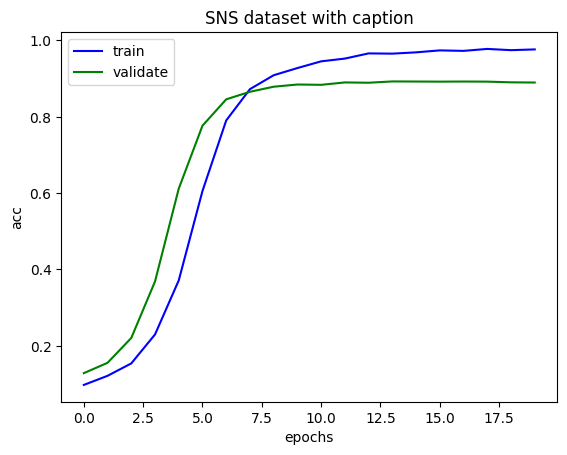

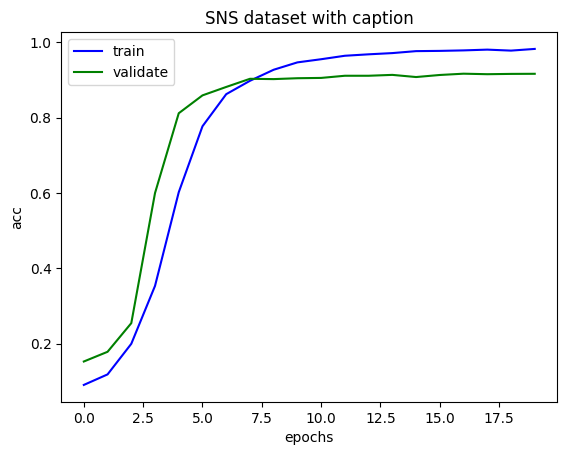

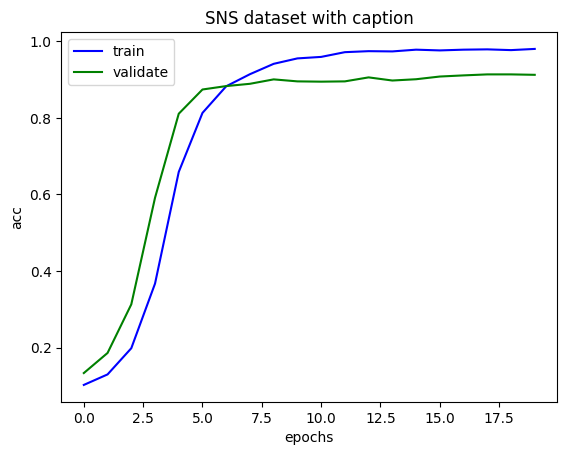

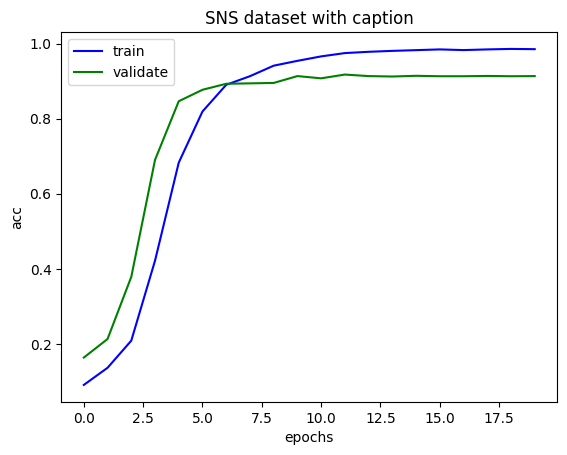

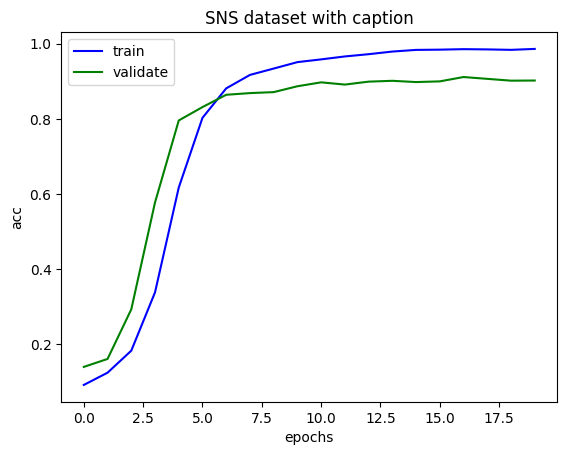

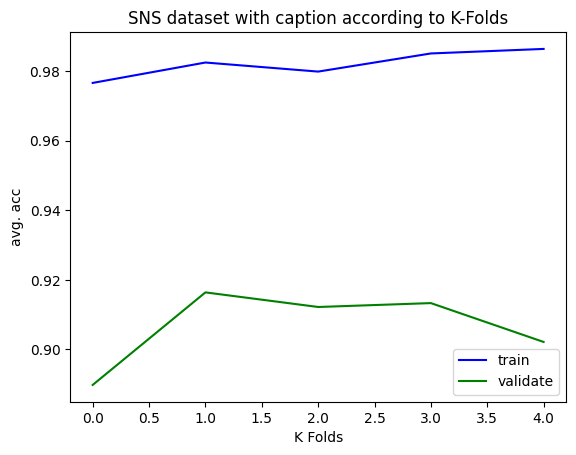

In [11]:
# groups = np.array([random.randint(0,6) for i in range(0,600)])
# gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
skf = StratifiedKFold(n_splits=n_splits)
#StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
nsplit =0
oldaccu = 0.0
trainarray = []
testarray =[]
# for trainidx, testidx in gss.split(np_data, np_label, groups=groups):
for trainidx,testidx in skf.split(np_data,np_label):
  # print("TRAIN:", trainidx, "TEST:", testidx)
  x_train,x_test,y_train,y_test = np_data[trainidx],np_data[testidx],np_label[trainidx],np_label[testidx]
  # print(x_train)
  # print(x_test)
  # print("%s %s" % (trainidx,testidx))
  data_train = BERTDataset(x_train, 1, 0, tok, max_len, True, False)
#   print("trainidx: ", len(trainidx))
#   print("x_train: ", len(x_train))
#   print("data_train: ", len(data_train))
  data_test = BERTDataset(x_test, 1, 0, tok, max_len, True, False)
  train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers) # before the num_workers = 5
  test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)  
  # load the initial model parameters
  checkpoint = torch.load('kobert.pt')
  model.load_state_dict(checkpoint['modelA'])
  optimizer.load_state_dict(checkpoint['optimizerA'])
  model.to(device)

  t_total = len(train_dataloader) * num_epochs
  warmup_step = int(t_total * warmup_ratio)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
  trainacclist =[]
  testacclist =[]
  # model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
  # optimizer.step()
  # print("train_dataloader: ", len(train_dataloader))
 
  for e in range(num_epochs):
      train_acc = 0.0
      test_acc = 0.0
      model.train()
      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
          optimizer.zero_grad()
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)
          out = model(token_ids, valid_length, segment_ids)
          loss = loss_fn(out, label)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()
          scheduler.step()  # Update learning rate schedule
          train_acc += calc_accuracy(out, label)
          if batch_id % log_interval == 0:
              # print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
              print('Epoch {}/{} Batch {}/{} Cost: {:.6f} Train Acc {}'.format(e+1, num_epochs, batch_id+1, len(train_dataloader), loss.item(), train_acc / (batch_id+1)))
#       print("batch id: ", batch_id)
#       print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
      print('\nEpoch {}/{} Cost: {:.6f} Train Acc {}'.format(e+1, num_epochs, loss.item(), train_acc / len(train_dataloader)))
      trainacclist.append(train_acc / (batch_id+1))
      model.eval()
      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)
          out = model(token_ids, valid_length, segment_ids)
          test_acc += calc_accuracy(out, label)
      # print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
      print('\nEpoch {}/{} Cost: {:.6f} Test Acc {}'.format(e+1, num_epochs, loss.item(), test_acc / len(test_dataloader)))
      testacclist.append(test_acc / (batch_id+1))
      newaccu = test_acc / (batch_id+1)
      if newaccu > oldaccu:
        oldaccu = newaccu
        torch.save(model, model_name)
      gc.collect()  
  plt.figure()
  print(trainacclist)
  trainarray.append(trainacclist[-1])
  print(testacclist)
  testarray.append(testacclist[-1])
  x = np.arange(len(trainacclist))
  plt.plot(x,trainacclist,'b',label='train')
  plt.plot(x,testacclist,'g',label='validate')
  # plt.axis('equal')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.title('SNS dataset with caption')
  # plt.setp(lines, color='r', linewidth=2.0)
  plt.legend()
  plt.savefig('128length{}.png'.format(nsplit),format='png')
  nsplit +=1

plt.figure()
x = np.arange(len(trainarray))
plt.plot(x,trainarray,'b',label='train')
plt.plot(x,testarray,'g',label='validate')
# plt.axis('equal')
plt.xlabel('K Folds')
plt.ylabel('avg. acc')
plt.title('SNS dataset with caption according to K-Folds')
# plt.setp(lines, color='r', linewidth=2.0)
plt.legend()
plt.savefig('128length{}.png'.format(nsplit),format='png')
nsplit +=1

print(np.array(trainarray))
print(np.array(testarray))

# pd.DataFrame(np.array(trainarray)).to_csv('trainaccu.csv')
# pd.DataFrame(np.array(testarray)).to_csv('testaccu.csv')

In [12]:
def precision_at_K (X,Y,K, np_testdata):
  max_vals1,max_indicesK = torch.topk(X,K)
  # print(max_indicesK)
  precisionnum = 0
  index = 0
  for yi, maxindicesi in zip(Y,max_indicesK):
    precisionnum += yi in maxindicesi
    if yi != maxindicesi:
        print("")
        print(yi, maxindicesi)
        print(np_testdata[index])
        print("")
    index += 1
  
  #maxlength = max_indicesK.size()[0] #precision_acc
  return precisionnum

In [13]:
data_test = BERTDataset(np_testdata, 1, 0, tok, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=num_workers) 
gc.collect()
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# tensor = torch.ones(())
# wholelabel =tensor.new_empty()
# wholeout =tensor.new_empty()
wholelabel =[]
wholeout =[]
categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
modelbest = torch.load(model_name)
modelbest.to(device)
modelbest.eval()
precision_at_3 =0.0
test_acc1 =0.0
start = 0
end = start + batch_size
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = modelbest(token_ids, valid_length, segment_ids)
        labellist = [categorylist[labeli] for labeli in label]
        outlist = [categorylist[outi.argmax()] for outi in out]
        wholelabel+=labellist
        wholeout+=outlist
        test_acc1 += calc_accuracy(out, label)
        precision_at_3 += precision_at_K (out,label,1, np_testdata[start:end])
        start += batch_size
        end = start + batch_size

# print(test_acc1*(batch_id+1)/len(data_test))
print(precision_at_3)
# print(totallength)
print((len(data_test)))
print("Total Acc", precision_at_3/len(data_test))
confusion_matrix(wholelabel, wholeout,labels= categorylist)
np.save('128confusionmatrix',confusion_matrix(wholelabel, wholeout,labels= categorylist))
confusion_matrix(wholelabel, wholeout,labels= categorylist)
print(confusion_matrix(wholelabel, wholeout,labels= categorylist))

print("accuracy:", accuracy_score(wholelabel, wholeout))
print("precision:", precision_score(wholelabel, wholeout,average = 'macro'))
print("Recall:", recall_score(wholelabel,wholeout,average='macro'))
print("F1_score:", f1_score(wholelabel,wholeout,average='macro'))

  0%|          | 0/15 [00:00<?, ?it/s]


tensor(0, device='cuda:4') tensor([1], device='cuda:4')
[0
 '제품협찬 페리페라 올테이크무드팔레트 호 봄바람아너는계획이있구나 가 출시되었어요 다가오는 봄에 아주 잘 어울리는 밀키한 색감의 팔레트예요 봄 라이트 분들께 진심 찰떡인 컬러들이라 강추 베이스 컬러부터 자연스러운 음영 글리터까지 구성이 정말 야무져요 특히 음영 컬러가 너무 어둡지 않은 자연스러운 색감이라 라이트톤 분들도 사용하기 좋을 거 같아요 올테이크 무드 팔레트는 정가 원인데 월 일부터 일까지 올리브영에서 할인해서 원에 만나볼 수 있어요 구 섀도우를 만 원대에 만나볼 수 있다니 봄바람아 너는 계획이 있구나 진심 강추합니다 그리고 맑게 물든 선샤인 치크도 뉴 컬러가 출시되었어요 호 아침잠좋아해는 화이트 베리 핑크 호 요거트얌얌해는 요거 밀키 피치 호 뒹굴뒹굴해는 진저 누드 베이지 컬러로 정말 맑고 햇살 가득 물들인 듯한 색감들로 출시되었어요 단독으로 발라도 예쁘고 컬러 섞어 발라도 예뻐요 호 먼저 바르고 그 위에 호를 발라도 색감이 오묘하니 예쁘더라고요 이번 신상들 추천드려요 봄웜라이트 웜톤팔레트 웜톤섀도우 봄웜팔레트 페리페라섀도우 섀도우팔레트추천 올리브영팔레트']


tensor(1, device='cuda:4') tensor([9], device='cuda:4')
[1
 '필라테스 교육동기이자 기 그란데라인 엠버서더 여신지혜님 의 추천으로 그란데라인 운동복 브랜드를 알게됐어요 칭찬이 자자해 궁금했는데 정말 감사하게도 기 엠버서더로 선정되어 예쁜 운동복을 입고 운동할 수 있게 됐어요 어제 스토리에 올리고 운동복 예쁘다고 해주신 분들이 많아서 기분이 무지무지 좋았는데 역시 실망시키지 않는 여성스런 디자인의 그란데라인 오랜만에 예쁜 운동복 입고 사진 장은 찍었어요 난 깔맞춤이 좋앙 상하의 운동복 요가복 그란데라인 그란데라인앰버서더 운동하는여자 운동하는간호사 필라테스 필라테스강사 눈바디']


tensor(1, device='cuda:4') tensor([


tensor(9, device='cuda:4') tensor([6], device='cuda:4')
[9
 '미리쌤이랑 수업하는동안 많은걸 배우고 느끼는 매 순간순간들 아직도 부족하고 나약한 나를 이렇게 성장시켜주신 그대는 역시 갓미리 선생님 인간미에 한번 더 반하게 되는 오늘 오늘 중간중간 눈물이 핑 포징은 역시 정미리선생님 이세상 비키니선수 들은 모두 미리쌤에게 팀보노짐 데일리운동 운동 다이어트 근력운동 유산소운동 스트레스 유지어터 수원 트레이너 권선동 수원 운동하는여자 그룹 운동하는남자 프로필사진 헬스타그램 몸스타그램 오늘의훈녀 헬스장 모델 정보스타그램']


tensor(9, device='cuda:4') tensor([6], device='cuda:4')
[9
 '아가를 기다리는 엄마의 노력 임산부 회원님들과 함께 기도하고 함께 노력해서 아기를 만날 날을 기다릴 수 있다는 건 저에게도 큰 축복이라고 생각해요 저 뿐 아니라 우리 강사님들은 현재 임산부 회원님들의 수업을 돕고 계세요 임신하고 소개로 오신분도 계시고 함께하다가 축복이 찾아온 경우도 있구요 덩달아 저희 스튜디오도 축복으로 가득찬 것 같아 행복한 요즘입니다 초애스튜디오 초애필라테스 한남동필라테스 이태원필라테스 옥수동필라테스 프라이빗레슨 필라테스 필라테스강사 운동하는여자 다이어트 운동 힐링 바시필라테스 다이어트식단 다이어트 홈트레이닝 스트레칭 임산부필라테스 키즈필라테스 골프필라테스 재활운동 재활필라테스 골프']


tensor(9, device='cuda:4') tensor([3], device='cuda:4')
[9
 '트레일러닝 써클인 기부 챌린지 일차 서울둘레길 코스 오늘 갑자기 눈이 빨리 떠져 급다녀온 둘레길 트레일러닝 산이랑 하늘보러 사실 저는 완주를 하지 못했어요 현재 만 완주 왜냐면 책자를 잃어버렸기 때문 속상하지만 그래도 둘레길 트레일러닝을 도전해 본것으로 만족하고 다음에 다시 도전 해보겠습니다 오늘의 코스 제 코스 가양역 번출구 가양대교 난지한강공원 월드컵경기장 불광천 봉산 앵